
# Case Study 5: Bayesian Neural Network

Adapted from https://num.pyro.ai/en/stable/examples/bnn.html , we first see the NumPyro implementation and then SOGA.


In [1]:
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time

### Training the BNN with VI in Pyro

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

torch.set_default_dtype(torch.float32)

In [3]:
# the non-linearity we use in our neural network
def nonlin(x):
    return F.relu(x)

X.shape torch.Size([10, 1, 1]) Y.shape torch.Size([10, 1, 1])


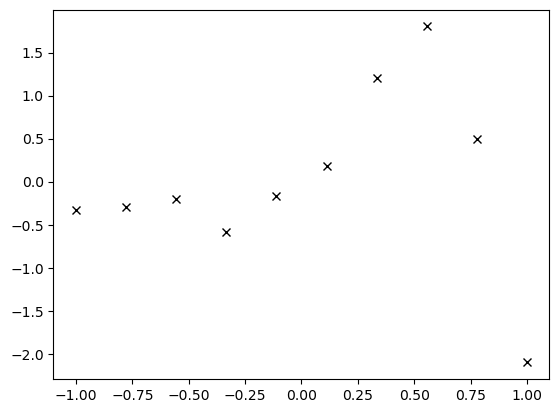

In [4]:
# Create artificial regression dataset

# Ensure all tensors are of dtype torch.float32
def get_data(N, D_X, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = np.linspace(-1, 1, N)
    X = np.power(X[:, np.newaxis], np.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = np.dot(X, W) + 0.5 * np.power(0.5 + X[:, 1], 2.0) * np.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= np.mean(Y)
    Y /= np.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = np.linspace(-1.3, 1.3, N_test)
    X_test = np.power(X_test[:, np.newaxis], np.arange(D_X))

    # Convert all tensors to float32
    return (
        torch.tensor(X[:, 1:2], dtype=torch.float32),
        torch.tensor(Y, dtype=torch.float32),
        torch.tensor(X_test[:, 1:2], dtype=torch.float32),
    )

args = [10, 2, 2]
N, D_X, D_H = args
X, Y, X_test = get_data(N=N, D_X=D_X)
X = X.unsqueeze(-1)
Y = Y.unsqueeze(-1)

print('X.shape', X.shape, 'Y.shape', Y.shape)
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx")



In [5]:
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
from pyro.distributions import constraints
import pyro.distributions as dist

def model(X, Y, D_H, D_Y=1):
    D_X = 1  # Number of input features
    N = X.shape[0]  # Number of data points

    # Sample first layer weights and biases
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(D_X, D_H), torch.ones(D_X, D_H)).to_event(2))  # Shape: (1, 1, 2)
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(D_H), torch.ones(D_H)).to_event(1))  # Shape: (2,)

    # Broadcast w1 and b1 to match the batch size
    w1_broadcasted = w1.expand(N, -1, -1)  # Shape: (10, 1, 2)
    b1_broadcasted = b1.unsqueeze(0).unsqueeze(0).expand(N, 1, D_H)  # Shape: (10, 1, 2)

    # Perform batch matrix multiplication
    z1 = nonlin(torch.bmm(X, w1_broadcasted) + b1_broadcasted)  # Shape: (10, 1, D_H)

    # Sample final layer weights and biases
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(D_H, D_Y), torch.ones(D_H, D_Y)).to_event(2))  # Shape: (2, D_Y)
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(D_Y), torch.ones(D_Y)).to_event(1))  # Shape: (D_Y,)

    # Broadcast b3 to match the batch size
    b3_broadcasted = b3.unsqueeze(0).unsqueeze(0).expand(N, 1, D_Y)  # Shape: (10, 1, D_Y)

    # Compute final output
    z3 = torch.bmm(z1, w3.unsqueeze(0).expand(N, -1, -1)) + b3_broadcasted  # Shape: (10, 1, D_Y)

    # Observation noise (fixed for simplicity)
    sigma_obs = torch.tensor(0.1)

    # Use pyro.plate to handle batch dimensions
    with pyro.plate("data", N):
        pyro.sample("Y", dist.Normal(z3.squeeze(-1), sigma_obs).to_event(1), obs=Y.squeeze(-1))

# Define the guide function for VI
def guide(X, Y, D_H, D_Y=1):
    D_X = 1
    N = X.shape[0]  # Number of data points

    # Variational parameters for the first layer
    w1_loc = pyro.param("w1_loc", torch.zeros(D_X, D_H))
    w1_scale = pyro.param("w1_scale", torch.ones(D_X, D_H), constraint=constraints.positive)
    b1_loc = pyro.param("b1_loc", torch.zeros(D_H))
    b1_scale = pyro.param("b1_scale", torch.ones(D_H), constraint=constraints.positive)

    # Sample first layer weights and biases
    pyro.sample("w1", dist.Normal(w1_loc, w1_scale).to_event(2))
    pyro.sample("b1", dist.Normal(b1_loc, b1_scale).to_event(1))

    # Variational parameters for the final layer
    w3_loc = pyro.param("w3_loc", torch.zeros(D_H, D_Y))
    w3_scale = pyro.param("w3_scale", torch.ones(D_H, D_Y), constraint=constraints.positive)
    b3_loc = pyro.param("b3_loc", torch.zeros(D_Y))
    b3_scale = pyro.param("b3_scale", torch.ones(D_Y), constraint=constraints.positive)

    # Sample final layer weights and biases
    pyro.sample("w3", dist.Normal(w3_loc, w3_scale).to_event(2))
    pyro.sample("b3", dist.Normal(b3_loc, b3_scale).to_event(1))


# Function to train the BNN using Variational Inference
def train_vi(model, guide, X, Y, D_H, num_steps=10000, lr=0.01):
    pyro.clear_param_store()
    optimizer = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

    losses = []
    for step in range(num_steps):
        loss = svi.step(X, Y, D_H)
        losses.append(loss)
        if step % int(num_steps/10) == 0:
            print(f"Step {step} - Loss: {loss}")

    print("Training complete!")
    return losses

# Example usage

start = time()
losses = train_vi(model, guide, X, Y, D_H)
end = time()
print("Training time:", end - start)

Step 0 - Loss: 1722.0882568359375
Step 1000 - Loss: 490.8986921310425
Step 2000 - Loss: 490.54668629169464
Step 3000 - Loss: 498.34246772527695
Step 4000 - Loss: 270.504552423954
Step 5000 - Loss: 267.3667047023773
Step 6000 - Loss: 270.3149508237839
Step 7000 - Loss: 108.41548955440521
Step 8000 - Loss: 115.62836265563965
Step 9000 - Loss: 106.06889998912811
Training complete!
Training time: 16.48036789894104


In [6]:
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.detach().numpy()}")

w1_loc: [[-1.3121461  3.1425543]]
w1_scale: [[0.0616982  0.02250014]]
b1_loc: [ 0.8352216 -2.2128072]
b1_scale: [0.03537515 0.01827463]
w3_loc: [[-0.9850266]
 [-3.5231109]]
w3_scale: [[0.02712139]
 [0.10147487]]
b3_loc: [1.2544316]
b3_scale: [0.03223007]


In [7]:
def predict_vi(X_test, D_H=2, D_Y=1):
    """
    Predicts the output for a given test set X_test using the variational parameters
    learned via variational inference in Pyro.

    Args:
        X_test (torch.Tensor): The test input data.
        D_H (int): The number of hidden units in the hidden layer.
        D_Y (int): The number of output dimensions (default is 1).

    Returns:
        torch.Tensor: The predicted mean values for the test set.
    """
    # Retrieve learned variational parameters from Pyro's parameter store
    w1_loc = pyro.param("w1_loc")
    b1_loc = pyro.param("b1_loc")
    w3_loc = pyro.param("w3_loc")
    b3_loc = pyro.param("b3_loc")

    # Compute the activations of the hidden layer
    z1 = F.relu(torch.matmul(X_test, w1_loc) + b1_loc)

    # Compute the final output
    z3 = torch.matmul(z1, w3_loc) + b3_loc

    return z3

Y_train = predict_vi(X, D_H)

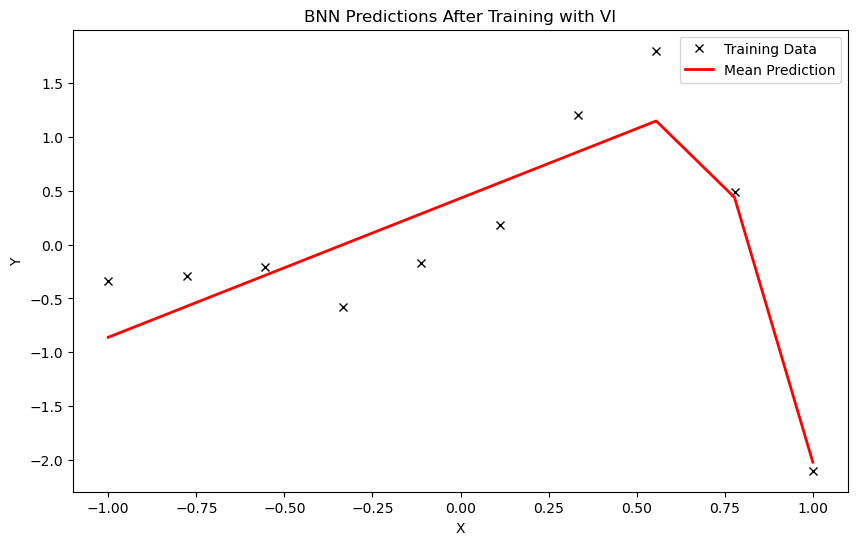

In [8]:


# Visualize the results of the BNN trained using Variational Inference
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx", label="Training Data")

# Predictive mean after training

# Plot mean prediction
plt.plot(X.squeeze(-1).numpy(), Y_train.squeeze(-1).detach().numpy(), "r", lw=2.0, label="Mean Prediction")

# Add labels, legend, and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("BNN Predictions After Training with VI")
plt.legend()

# Show the plot
plt.show()

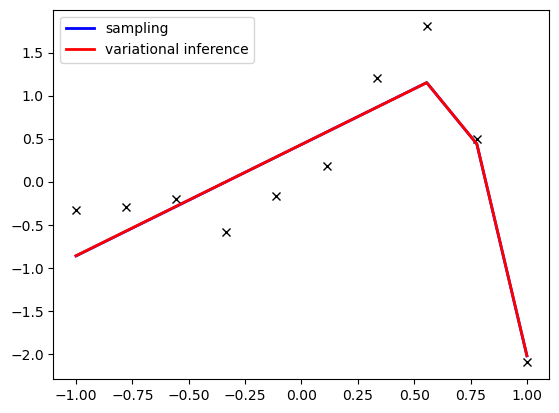

In [9]:
w1_mean, w2_mean = pyro.param("w1_loc").detach().numpy()[0]
w3_mean, w4_mean = pyro.param('w3_loc').detach().numpy()[:, 0]
b1_mean, b2_mean = pyro.param("b1_loc").detach().numpy()
b3_mean = pyro.param("b3_loc").detach().numpy()[0]

w1_std, w2_std = pyro.param("w1_scale").detach().numpy()[0]
w3_std, w4_std = pyro.param('w3_scale').detach().numpy()[:, 0]
b1_std, b2_std = pyro.param("b1_scale").detach().numpy()
b3_std = pyro.param("b3_scale").detach().numpy()[0]

from scipy.stats import norm

# Trying to replicate Pyro results

def predict_by_sample(X):

    Y = np.zeros(len(X))
    a1_list = []
    a2_list = []
    h1_list = []
    h2_list = []


    b1 = norm(loc=b1_mean, scale=b1_std).rvs()
    b2 = norm(loc=b2_mean, scale=b2_std).rvs()
    b3 = norm(loc=b3_mean, scale=b3_std).rvs()
    
    w1 = norm(loc=w1_mean, scale=w1_std).rvs()
    w2 = norm(loc=w2_mean, scale=w2_std).rvs()
    w3 = norm(loc=w3_mean, scale=w3_std).rvs()
    w4 = norm(loc=w4_mean, scale=w4_std).rvs()
    

    for i in range(10):
        h1 = max(w1 * X[i] + b1, 0)
        a1_list.append(w1 * X[i] + b1)
        h1_list.append(h1)
        h2 = max(w2 * X[i] + b2, 0)
        a2_list.append(w2 * X[i] + b2)
        h2_list.append(h2)
        Y[i] = w3 * h1 + w4 * h2 + b3

    return np.array(Y), np.array(a1_list), np.array(h1_list), np.array(a2_list), np.array(h2_list)

def sample_predictions(X, n_samples=1000):
    
    Y_samples = []
    a1_samples = []
    a2_samples = []
    h1_samples = []
    h2_samples = []

    for _ in range(n_samples):
        Y, a1, h1, a2, h2 = predict_by_sample(X)
        Y_samples.append(Y)
        a1_samples.append(a1)
        a2_samples.append(a2)
        h1_samples.append(h1)
        h2_samples.append(h2)

    return np.array(Y_samples), np.array(a1_samples), np.array(h1_samples), np.array(a2_samples), np.array(h2_samples)

Y_samples, _, _, _, _ = sample_predictions(X.numpy().flatten(), n_samples=1000)

Y_samples_mean = np.mean(Y_samples, axis=0)

plt.plot(X.numpy().flatten(), Y.numpy().flatten(), "kx")
plt.plot(X.numpy().flatten(), Y_samples_mean, "blue", ls="solid", lw=2.0, label='sampling')
plt.plot(X.squeeze(-1).numpy(), Y_train.squeeze(-1).detach().numpy(), "r", lw=2.0, label="variational inference")

plt.legend()


### Sanity check on SOGA program

We use the parameters found by VI in SOGA to check that the BNN is correctly encoded

In [41]:
def mean_squared_error(y_true, dist):
    return torch.mean((y_true - dist.gm.mean()) ** 2)

def mean_squared_error_bayes(y_true, dist):
    #This works for the means but of course not for the variances
    return torch.mean((y_true - dist.gm.mean()[:-2]) ** 2)

def neg_log_likelihood(y_true, dist):
    #Calculate the log-likelihood of the data given the distribution
    neg_log_likelihood = 0
    idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    neg_log_likelihood = - torch.log(dist.gm.marg_pdf(y_true, idx))
    return torch.sum(neg_log_likelihood)

def neg_log_likelihood_one(y_true, dist):
    #Calculate the log-likelihood of the single data point given the distribution
    return - torch.log(dist.gm.marg_pdf(y_true, dist.var_list.index('y')))

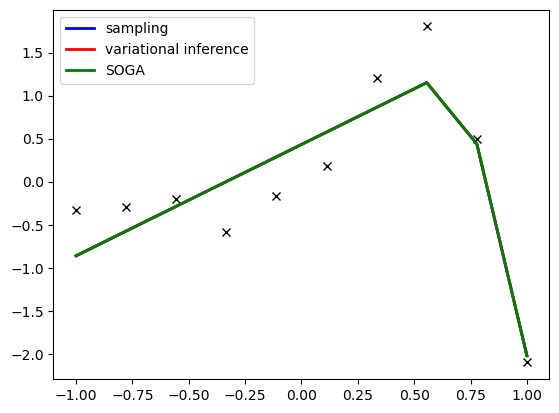

In [11]:
# What happens if we use the parameters found by MCMC in SOGA?

# This is the X vector used in the script
X_soga = torch.tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556, 0.7778,  1.0000])

compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn3.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

vi_pars = {'muw1':w1_mean, 'muw2': w2_mean, 'muw3': w3_mean, 'muw4': w4_mean, 'mub1': b1_mean, 'mub2': b2_mean, 'mub3': b3_mean,
             'sigmaw1': w1_std, 'sigmaw2': w2_std, 'sigmaw3': w3_std, 'sigmaw4': w4_std, 'sigmab1': b1_std, 'sigmab2': b2_std, 'sigmab3': b3_std}

for key, value in vi_pars.items():
    vi_pars[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, vi_pars, pruning='ranking') #params_dict 


plt.plot(X.numpy().flatten(), Y.numpy().flatten(), "kx")
plt.plot(X.numpy().flatten(), Y_samples_mean, "blue", ls="solid", lw=2.0, label='sampling')
plt.plot(X.squeeze(-1).numpy(), Y_train.squeeze(-1).detach().numpy(), "r", lw=2.0, label="variational inference")
plt.plot(X_soga.numpy().flatten(), output_dist.gm.mean()[:10].detach().numpy(), "green", ls="solid", lw=2.0, label='SOGA')

plt.legend()


In [12]:
print('loss with optimal parameter:', neg_log_likelihood(Y.squeeze(-1).t(), output_dist))

loss with optimal parameter: tensor(59.3572, grad_fn=<SumBackward0>)


### Optimization in SOGA

We use a different script in which the std of the weights are fixed (if not the loss is better for higher stds).
Moreover we add noise to the output to avoid infinite loss

In [13]:
from libSOGA import *
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *

def optimize(params_dict, loss_function, y, cfg, steps=500, lr=0.01):
    optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr)

    total_start = time()

    for i in range(steps):

        optimizer.zero_grad()  # Reset gradients
        
        # loss
        current_dist = start_SOGA(cfg, params_dict, pruning='ranking')

        loss = loss_function(y, current_dist)

        # Backpropagate
        loss.backward(retain_graph=True)
        
        optimizer.step()

        # Print progress
        if i % int(steps/10) == 0:
            out = ''
            
            out = out + f" loss: {loss.item()}"

            for key in params_dict.keys():
                out = out + key + ': ' + str(params_dict[key].item()) + ' '
                
            print(out)

    total_end = time()

    print('Optimization performed in ', round(total_end-total_start, 3))

SOGA time w init params: 1.5489039421081543
loss with initial parameters: tensor(22.7091, grad_fn=<SumBackward0>)
SOGA time w opt params: 0.0838019847869873
loss with opt parameters: tensor(7.7148, grad_fn=<SumBackward0>)


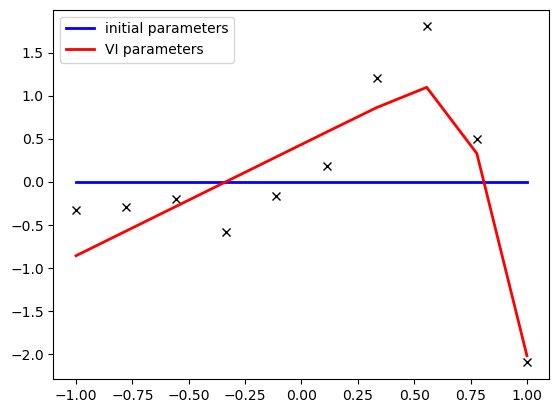

In [14]:
torch.set_default_dtype(torch.float64)

# Check that the initial parameters do not give infinite loss and that optimal parameters decrease the loss

compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn3_mean_only.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

vi_pars_init = {'muw1': -0. , 'muw2': 0., 'muw3': 0., 'muw4': 0., 'mub1': 0., 'mub2': 0., 'mub3': 0.}

for key, value in vi_pars_init.items():
    vi_pars_init[key] = torch.tensor(value, requires_grad=True)    

start = time()
output_dist_init = start_SOGA(cfg, vi_pars_init, pruning='ranking') 
end = time()
print("SOGA time w init params:", end - start)

print('loss with initial parameters:', neg_log_likelihood(Y.squeeze(-1).t(), output_dist_init))#


compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn3_smooth.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg, smooth_eps=1e-2)

vi_pars_opt = {'muw1': w1_mean, 'muw2': w2_mean, 'muw3': w3_mean, 'muw4': w4_mean, 'mub1': b1_mean, 'mub2': b2_mean, 'mub3': b3_mean}

for key, value in vi_pars_opt.items():
    vi_pars_opt[key] = torch.tensor(value, requires_grad=True)    

start = time()
output_dist_opt = start_SOGA(cfg, vi_pars_opt, pruning='ranking')
end = time()
print("SOGA time w opt params:", end - start)

print('loss with opt parameters:', neg_log_likelihood(Y.squeeze(-1).t(), output_dist_opt))


plt.plot(X.numpy().flatten(), Y.numpy().flatten(), "kx")
plt.plot(X.numpy().flatten(), output_dist_init.gm.mean()[:10].detach().numpy(), "blue", ls="solid", lw=2.0, label ='initial parameters')
plt.plot(X.numpy().flatten(), output_dist_opt.gm.mean()[:10].detach().numpy(), "red", ls="solid", lw=2.0, label='VI parameters')
plt.legend()

In [15]:
from libSOGA import *
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from time import time


# Some values of the parameters break the program

compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn3_mean_only.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg, smooth_eps=1e-2)

vi_pars_init = {'muw1': -1.0, 'muw2': 1.0, 'muw3': -1.0, 'muw4': -1.0, 'mub1': 1.0, 'mub2': -1.0, 'mub3': 1.0}
#vi_pars_init = {'muw1': -0.5 , 'muw2': 2., 'muw3': -1., 'muw4': -3., 'mub1': 1., 'mub2': -2., 'mub3': 0.5}


for key, value in vi_pars_init.items():
    vi_pars_init[key] = torch.tensor(value, requires_grad=True)    

start = time()
output_dist_init = start_SOGA(cfg, vi_pars_init, pruning='ranking') 
end = time()
print("SOGA time w init params:", end - start)

print('loss with initial parameters:', neg_log_likelihood(Y.squeeze(-1).t(), output_dist_init))


SOGA time w init params: 0.10822820663452148
loss with initial parameters: tensor(21.8885, grad_fn=<SumBackward0>)


In [16]:
# Actual Optimization

vi_pars_init = {'muw1': -1.0, 'muw2': 1.0, 'muw3': -1.0, 'muw4': -1.0, 'mub1': 1.0, 'mub2': -1.0, 'mub3': 1.0}
#vi_pars_init = {'muw1': -0.5 , 'muw2': 2., 'muw3': -1., 'muw4': -3., 'mub1': 1., 'mub2': -2., 'mub3': 0.5}


for key, value in vi_pars_init.items():
    vi_pars_init[key] = torch.tensor(value, requires_grad=True)    


compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn3_mean_only.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

optimize(vi_pars_init, neg_log_likelihood, Y.squeeze(-1).t(), cfg, steps=100, lr = 0.0001)

#predictive mean
#y_pred = params_dict['muw'].detach().numpy()*X.detach().numpy()+params_dict['mub'].detach().numpy()

#predictive variance
#sigma_y_pred = np.sqrt(params_dict['sigmay'].detach().numpy()**2 + (X.detach().numpy()*params_dict['sigmaw'].detach().numpy())**2 + params_dict['sigmab'].detach().numpy()**2)



 loss: 21.892717483586143muw1: -0.9999000000009733 muw2: 1.0000999999998714 muw3: -0.9999000000003269 muw4: -1.0000999999997904 mub1: 0.99990000000036 mub2: -0.9999000000001532 mub3: 0.9999000000004429 
 loss: 21.864560075822922muw1: -0.9989006852762398 muw2: 1.0010999454489198 muw3: -0.9989002191622074 muw4: -1.0011000021355956 mub1: 0.9988999763996564 mub2: -0.9989001320933731 mub3: 0.9989001188833905 
 loss: 21.83648119831006muw1: -0.9979044235758396 muw2: 1.0020996484840907 muw3: -0.9979014099401666 muw4: -1.0021000121372263 mub1: 0.9978998500000686 mub2: -0.997900850677716 mub3: 0.9979007640295275 
 loss: 21.808489776586384muw1: -0.9969133544073903 muw2: 1.0030989410318074 muw3: -0.9969042408017622 muw4: -1.0031000317455732 mub1: 0.9968995534603381 mub2: -0.9969025613671783 mub3: 0.9969022948498647 
 loss: 21.78059170978362muw1: -0.9959289463957537 muw2: 1.0040977101706479 muw3: -0.9959091558993862 muw4: -1.0041000584928719 mub1: 0.9958990440789504 mub2: -0.9959055359213871 mub3: 

In [17]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn3_mean_only.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

output_dist = start_SOGA(cfg, vi_pars_init, pruning='ranking')

neg_log_likelihood(Y.squeeze(-1).t(), output_dist)

tensor(21.6153, grad_fn=<SumBackward0>)

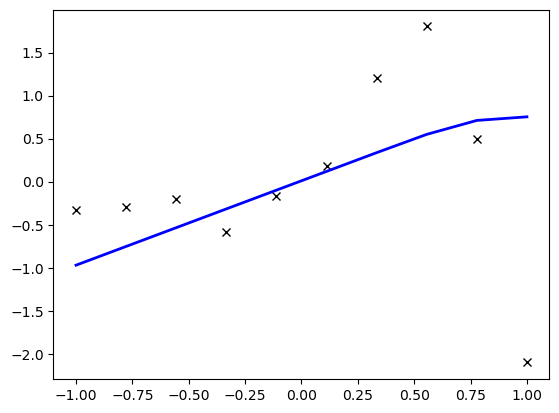

In [18]:
# plot training data
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx")
# plot 90% confidence level of predictions
#plt.fill_between(X.numpy().flatten(), percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
plt.plot(X.numpy().flatten(), output_dist.gm.mean()[:10].detach().numpy(), "blue", ls="solid", lw=2.0)
#ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

plt.savefig('loss12-prune1500-101s.pdf')
plt.show()


### BNN with one input at a time

In [58]:
torch.set_default_dtype(torch.float64)

bnn_one_pars = {'muw1': -1.0, 'muw2': 1.0, 'muw3': -1.0, 'muw4': -1.0, 'mub1': 1.0, 'mub2': -1.0, 'mub3': 1.0}
#vi_pars_init = {'muw1': -0.5 , 'muw2': 2., 'muw3': -1., 'muw4': -3., 'mub1': 1., 'mub2': -2., 'mub3': 0.5}


for key, value in bnn_one_pars.items():
    bnn_one_pars[key] = torch.tensor(value, requires_grad=True)    


compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn_one_x.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

lr = 0.001
steps = 2000

#optimize(bnn_one_pars, neg_log_likelihood, Y.squeeze(-1).t(), cfg, steps=100, lr = 0.0001)

optimizer = torch.optim.Adam([bnn_one_pars[key] for key in bnn_one_pars.keys()], lr)

total_start = time()

for i in range(steps):

    optimizer.zero_grad()  # Reset gradients
    loss = 0
    for j in range(len(Y.squeeze([-1,1]))):
        yj = Y.squeeze([1])[j].to(torch.float64)
        xj = X.squeeze([-1,1])[j]
        bnn_one_pars['x'] = xj.requires_grad_(False)

        current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')

        loss += neg_log_likelihood_one(yj, current_dist)

    # Backpropagate
    loss.backward(retain_graph=True)
    
    optimizer.step()

    # Print progress
    if i % int(steps/10) == 0:
        out = ''
        
        out = out + f" loss: {loss.item()}"

        for key in bnn_one_pars.keys():
            out = out + key + ': ' + str(bnn_one_pars[key].item()) + ' '
            
        print(out)

    total_end = time()

print('Optimization performed in ', round(total_end-total_start, 3))

 loss: 20.02730356675318muw1: -0.9990000000014023 muw2: 1.0009999999985633 muw3: -0.9990000000021622 muw4: -1.0009999999967834 mub1: 0.9990000000084546 mub2: -0.9990000000014404 mub3: 1.0009999999518855 x: 1.0 
 loss: 14.913073382512259muw1: -0.8465147909832778 muw2: 1.2024319885443027 muw3: -0.85473320770215 muw4: -1.2157140807885927 mub1: 0.7873782250419965 mub2: -0.7999499362299506 mub3: 0.8169263299433006 x: 1.0 
 loss: 12.33048012711414muw1: -0.8470128826105427 muw2: 1.358165903907099 muw3: -0.8622417072447189 muw4: -1.4151559526217952 mub1: 0.5604132473447028 mub2: -0.6670339119668012 mub3: 0.7473638392298936 x: 1.0 
 loss: 11.331317071659578muw1: -0.9254986165061915 muw2: 1.4552705338254242 muw3: -0.9658072812480536 muw4: -1.5749809010115736 mub1: 0.5043300952784637 mub2: -0.6329604400070324 mub3: 0.8352773801011232 x: 1.0 
 loss: 10.720632268684497muw1: -0.9951958476860607 muw2: 1.5314189438077686 muw3: -1.0466669061231992 muw4: -1.717673196567278 mub1: 0.5348479728838939 mub2:

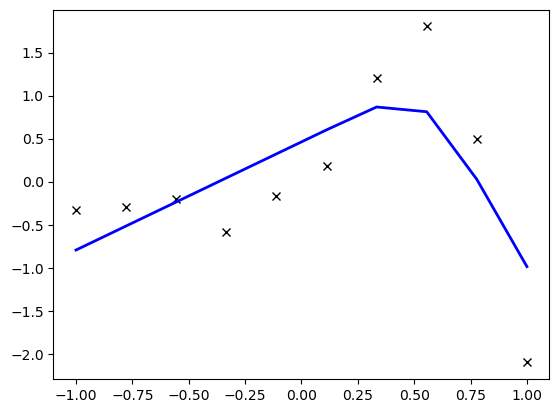

In [59]:
y_means = []
for j in range(len(Y.squeeze([-1,1]))):
    yj = Y.squeeze([1])[j].to(torch.float64)
    xj = X.squeeze([-1,1])[j]
    bnn_one_pars['x'] = xj.requires_grad_(False)

    current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')
    y_means.append(current_dist.gm.mean()[current_dist.var_list.index('y')].detach().numpy())

# plot training data
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx")
# plot 90% confidence level of predictions
#plt.fill_between(X.numpy().flatten(), percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
plt.plot(X.numpy().flatten(), y_means, "blue", ls="solid", lw=2.0)
#ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")
plt.show()

### Let's try with batches of n elements

In [62]:
batch_size = 6

bnn_one_pars = {'muw1': -1.0, 'muw2': 1.0, 'muw3': -1.0, 'muw4': -1.0, 'mub1': 1.0, 'mub2': -1.0, 'mub3': 1.0}
#vi_pars_init = {'muw1': -0.5 , 'muw2': 2., 'muw3': -1., 'muw4': -3., 'mub1': 1., 'mub2': -2., 'mub3': 0.5}


for key, value in bnn_one_pars.items():
    bnn_one_pars[key] = torch.tensor(value, requires_grad=True)    


compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bnn_one_x.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

lr = 0.001
steps = 2000

#optimize(bnn_one_pars, neg_log_likelihood, Y.squeeze(-1).t(), cfg, steps=100, lr = 0.0001)

optimizer = torch.optim.Adam([bnn_one_pars[key] for key in bnn_one_pars.keys()], lr)

total_start = time()

for i in range(steps):

    optimizer.zero_grad()  # Reset gradients
    loss = 0
    for j in range(batch_size):
        # Randomly select a data point
        sampled_index = np.random.randint(0, len(Y.squeeze([-1,1])))
        yj = Y.squeeze([1])[sampled_index].to(torch.float64)
        xj = X.squeeze([-1,1])[sampled_index]
        bnn_one_pars['x'] = xj.requires_grad_(False)

        current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')

        loss += neg_log_likelihood_one(yj, current_dist)

    # Backpropagate
    loss.backward(retain_graph=True)
    
    optimizer.step()

    # Print progress
    if i % int(steps/10) == 0:
        out = ''
        
        out = out + f" loss: {loss.item()}"

        for key in bnn_one_pars.keys():
            out = out + key + ': ' + str(bnn_one_pars[key].item()) + ' '
            
        print(out)

    total_end = time()

print('Optimization performed in ', round(total_end-total_start, 3))

 loss: 28.248394879642035muw1: -0.9990000000006786 muw2: 1.0009999999992782 muw3: -0.9990000000180508 muw4: -1.000999999998392 mub1: 1.0009999999986616 mub2: -0.9990000000007234 mub3: 0.9990000000011579 x: -1.0 
 loss: 3.4867273887035912muw1: -0.8864988864709754 muw2: 1.1350353226414502 muw3: -0.9100392436157874 muw4: -1.141049020855446 mub1: 1.000934221363115 mub2: -0.8662108638851972 mub3: 0.984511087818054 x: -0.1111111119389534 
 loss: 3.19167937498423muw1: -0.8093843434074232 muw2: 1.255316247600265 muw3: -0.8628936927630408 muw4: -1.2796163651015697 mub1: 0.9944109590377258 mub2: -0.7523240435595105 mub3: 0.9785597327470956 x: -0.3333333432674408 
 loss: 12.59575653353178muw1: -0.7788029593225865 muw2: 1.3367781445797233 muw3: -0.8406001628874745 muw4: -1.3886256683033984 mub1: 0.9687247180980852 mub2: -0.6876496511268045 mub3: 0.992260691557629 x: 0.5555555820465088 
 loss: 10.045565877694012muw1: -0.763652151907185 muw2: 1.409648758904265 muw3: -0.8388894067566179 muw4: -1.4972

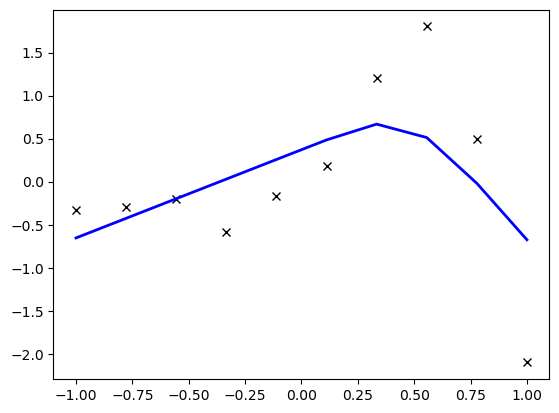

In [63]:
y_means = []
for j in range(len(Y.squeeze([-1,1]))):
    yj = Y.squeeze([1])[j].to(torch.float64)
    xj = X.squeeze([-1,1])[j]
    bnn_one_pars['x'] = xj.requires_grad_(False)

    current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')
    y_means.append(current_dist.gm.mean()[current_dist.var_list.index('y')].detach().numpy())

# plot training data
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx")
# plot 90% confidence level of predictions
#plt.fill_between(X.numpy().flatten(), percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
plt.plot(X.numpy().flatten(), y_means, "blue", ls="solid", lw=2.0)
#ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")
plt.show()